<a href="https://colab.research.google.com/github/gbatt55/ai-ontology-map/blob/main/notebooks/visualize_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gbatt55/ai-ontology-map/blob/main/notebooks/visualize_graph.ipynb)

# AI Supply Chain Ontology — Graph Visualizer

This notebook visualizes the ontology graph defined in `ontology.json`.

Behavior:
- Downloads `ontology.json` from your GitHub repo into Colab.
- Builds a directed graph using NetworkX.
- Visualizes selected layers.

Edit the `selected_layers` list below to control which layers are shown.


In [46]:
# Install and import dependencies
!pip install networkx

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np
import os
import json
import urllib.request


In [47]:
RAW_URL = "https://raw.githubusercontent.com/gbatt55/ai-ontology-map/main/ontology.json"
DOWNLOAD_PATH = "/content/ontology.json"

print("Downloading ontology.json from GitHub (force refresh)...")
urllib.request.urlretrieve(RAW_URL, DOWNLOAD_PATH)

with open(DOWNLOAD_PATH, "r") as f:
    data = json.load(f)

nodes = data["nodes"]
edges = data["edges"]

print("Loaded", len(nodes), "nodes and", len(edges), "edges")


Loaded 26 nodes and 42 edges


/tmp/ipython-input-4187265567.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')


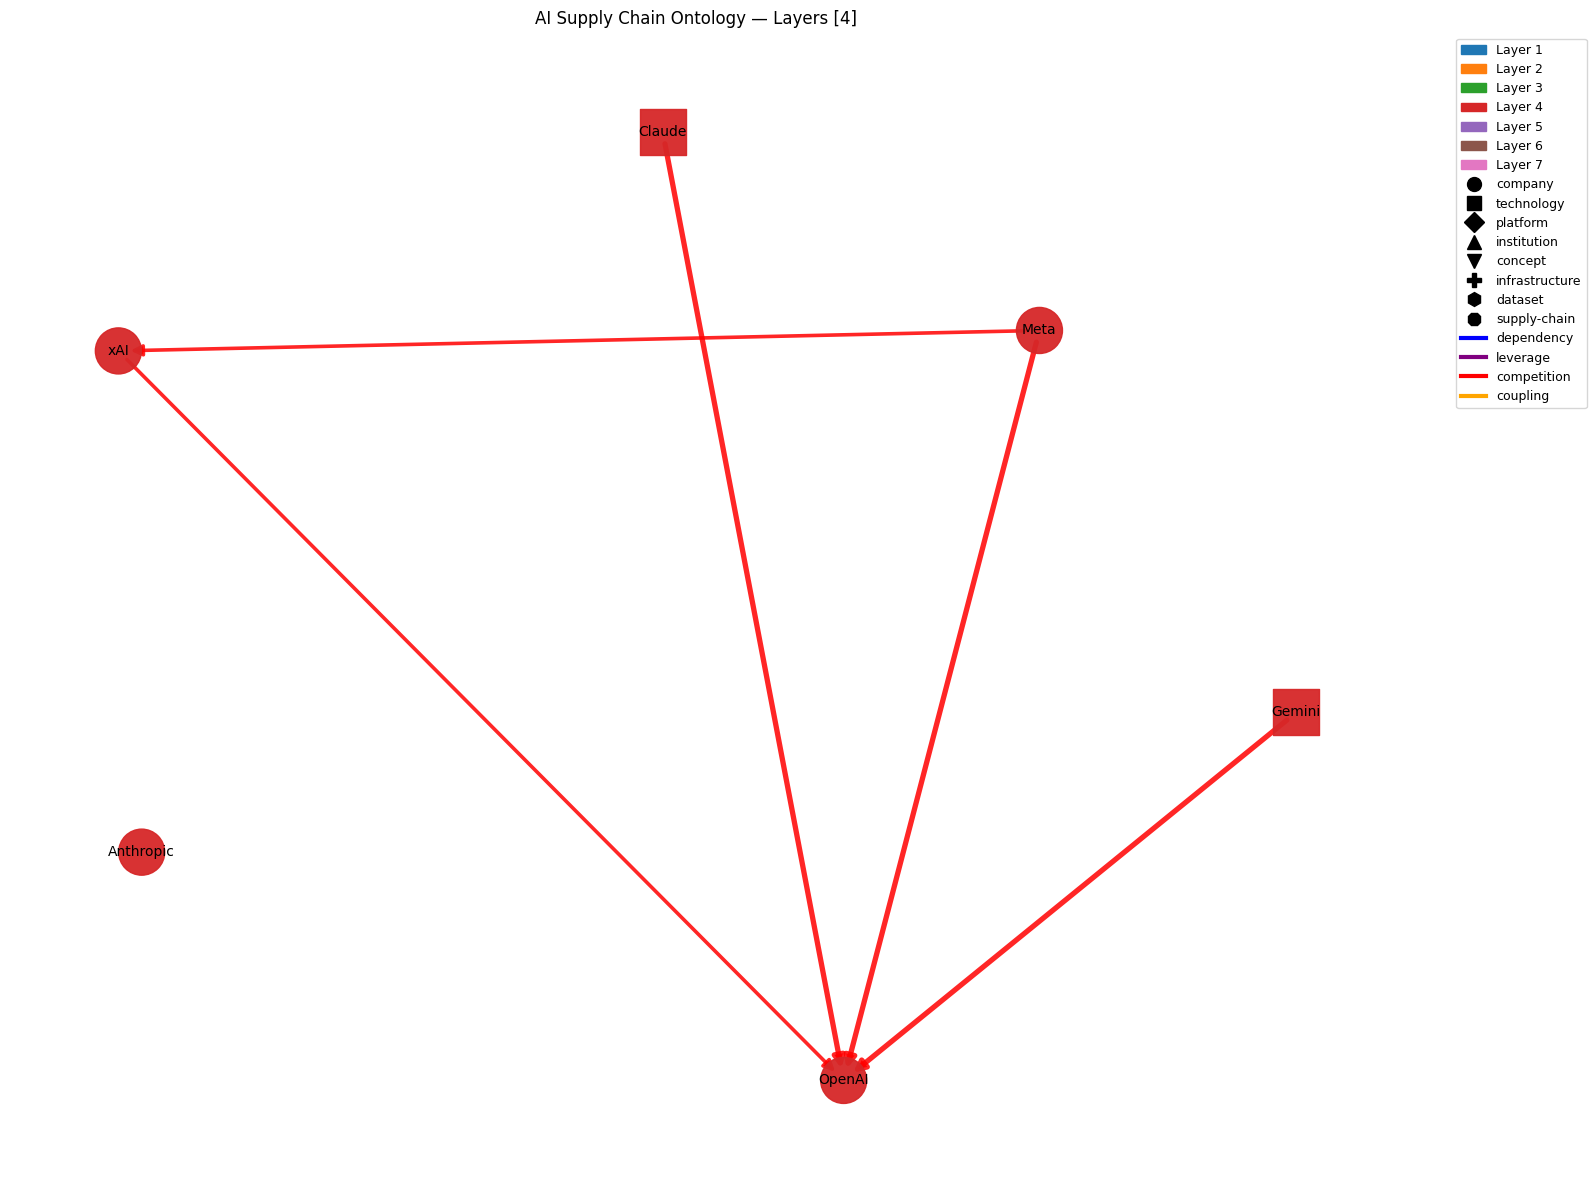

Layers present in this view: [4]


In [48]:
# === CONFIG — SELECT LAYERS TO VISUALIZE ===
# Example:
#   [2]       → only Layer 2
#   [1,2,3]   → Layers 1–3
#   []        → ALL layers

selected_layers = [4]  # <-- edit this line as needed

# === BUILD GRAPH ===
G = nx.DiGraph()

for n in nodes:
    G.add_node(n["id"], **n)

for e in edges:
    G.add_edge(e["source"], e["target"], **e)

# === FILTER BY LAYERS ===
if selected_layers:
    H = nx.DiGraph()
    for node_id, attrs in G.nodes(data=True):
        if attrs.get("layer") in selected_layers:
            H.add_node(node_id, **attrs)
    for u, v, attrs in G.edges(data=True):
        if u in H.nodes and v in H.nodes:
            H.add_edge(u, v, **attrs)
else:
    H = G.copy()

if H.number_of_nodes() == 0:
    print("No nodes to display for selected_layers =", selected_layers)
else:
    # === STYLED, LAYER-AWARE VISUALIZATION ===

    # Color map and style dictionaries
    cmap = plt.cm.get_cmap('tab10')

    NODE_SHAPES = {
        "company": "o",
        "technology": "s",
        "platform": "D",
        "institution": "^",
        "concept": "v",
        "infrastructure": "P",
        "dataset": "h",
        "supply-chain": "8",
    }

    EDGE_COLORS = {
        "dependency": "blue",
        "leverage": "purple",
        "competition": "red",
        "coupling": "orange",
    }

    def edge_width(weight: float) -> float:
        """Map edge weight (0–1) to a visible line width."""
        return 1 + 4 * weight

    # --- Layer-aware initial layout ---
    layer_positions = {}
    y_scaling = 1.5

    for n_id, attrs in H.nodes(data=True):
        layer = attrs.get("layer", 4)
        layer_positions[n_id] = (
            layer + 0.2 * np.random.randn(),
            -layer * y_scaling + 0.1 * np.random.randn(),
        )

    # Refine with spring_layout but keep layers roughly separated
    pos = nx.spring_layout(H, pos=layer_positions, seed=42, k=1.0)

    plt.figure(figsize=(16, 12))

    # --- Draw nodes by type (shape) and layer (color) ---
    for node_type, shape in NODE_SHAPES.items():
        nodes_of_type = [n_id for n_id, d in H.nodes(data=True) if d.get("type") == node_type]
        if not nodes_of_type:
            continue

        nx.draw_networkx_nodes(
            H,
            pos,
            nodelist=nodes_of_type,
            node_color=[cmap((H.nodes[n]["layer"] - 1) % 10) for n in nodes_of_type],
            node_shape=shape,
            node_size=1100,
            alpha=0.95,
        )

    # --- Draw edges with color + width based on type/weight ---
    for (u, v, d) in H.edges(data=True):
        e_type = d.get("type", "dependency")
        weight = d.get("weight", 0.4)

        nx.draw_networkx_edges(
            H,
            pos,
            edgelist=[(u, v)],
            arrowstyle="-|>",
            arrowsize=16,
            width=edge_width(weight),
            edge_color=EDGE_COLORS.get(e_type, "gray"),
            alpha=0.85,
        )

    # --- Node labels ---
    labels = {n_id: H.nodes[n_id].get("name", n_id) for n_id in H.nodes}
    nx.draw_networkx_labels(H, pos, labels, font_size=10)

    # --- Legend: layers, node types, edge types ---
    layer_patches = [
        mpatches.Patch(color=cmap(i), label=f"Layer {i+1}") for i in range(7)
    ]

    node_handles = [
        mlines.Line2D([], [], color="black", marker=shape, linestyle="None", markersize=10, label=typ)
        for typ, shape in NODE_SHAPES.items()
    ]

    edge_handles = [
        mlines.Line2D([], [], color=color, linewidth=3, label=etype)
        for etype, color in EDGE_COLORS.items()
    ]

    plt.legend(
        handles=layer_patches + node_handles + edge_handles,
        loc="upper left",
        bbox_to_anchor=(1.05, 1.0),
        fontsize=9,
    )

    title = "AI Supply Chain Ontology — Layers " + (str(selected_layers) if selected_layers else "ALL")
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    present_layers = sorted({d.get("layer") for _, d in H.nodes(data=True)})
    print("Layers present in this view:", present_layers)
